Imports

In [118]:
import json
from pycsp3 import *
import matplotlib.pyplot as plt
from matplotlib import patheffects
import tkinter as tk
from tkinter import filedialog

In [119]:
def select_file():
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(filetypes=[("JSON files", "*.json"), ("PL files", "*.pl")])
    root.destroy()  # Close the Tkinter window
    return file_path

Function to visualize results

In [120]:
def draw_schedule(activities, end, width=15, height=8):
    n_machines=len(activities)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.set_xlim(0, end+1)
    ax.set_ylim(0, n_machines + 1)
    for i, activity_line in enumerate(activities, start=1):
        for activity in activity_line:
            start_time = activity['start_time']
            duration = activity['duration']
            end_time = start_time + duration
            ax.plot([start_time, end_time], [i, i], linewidth=20, solid_capstyle='butt')
            text_x = (start_time + end_time) / 2
            text_y = i
            mytxt = ax.text(text_x, text_y, activity['name'], ha='center', va='center', color='white', fontsize=12)
            mytxt.set_path_effects([patheffects.withStroke(linewidth=3, foreground='black')])

    ax.set_yticks(range(1, n_machines + 1))
    ax.set_yticklabels([f'Machine {i}' for i in range(1, n_machines+1)])
    ax.set_xlabel('Time')
    ax.set_title("Tasks execution took "+str(end)+" units of time")
    plt.grid(True)
    plt.show()


reading data from a .pl or .json file

In [121]:
def read_input(input_file):
    global n_ressources
    global machines_array
    global tasks_array
    machines_array = set()
    tasks_array = []

    if input_file.endswith('.pl'):
        with open(input_file, 'r') as file:
            for line in file:
                if line.startswith('test('):
                    big_parts = line.split('[')
                    duration = int(big_parts[0].split(',')[1].strip())
                    
                    machines = big_parts[1].replace(' ','').replace(']', '').replace("'", '').replace('m', '').split(',')
                    machines = [(int(machine)-1) for machine in machines if machine.isdigit()]
                    
                    resources = big_parts[2].split(']')[0].replace(' ','').replace('[', '').replace("'", '').replace('r', '').split(',')
                    resources = [(int(resource)-1) for resource in resources if len(resource)>0]
                    
                    if len(machines)>0:
                        tasks_array.append([duration, machines, resources])
                    else:
                        tasks_array.append([duration, machines_array, resources])

                elif line.startswith('% Number of machines'):
                    machines_array = sorted(range (int(line.split(':')[1].strip())))
                elif line.startswith('% Number of resources'):
                    n_ressources = int(line.split(':')[1].strip())

    elif input_file.endswith('.json'):
        file = open(input_file)
        file_data = json.load(file)
        n_ressources=file_data['nResources']
        machines_array = sorted(range (int(file_data['nMachines'])))
        for task in file_data['tests']:
            if len(task['machines'])>0:
                tasks_array.append([int(task['duration']), task['machines'], task['resources']])
            else:
                tasks_array.append([int(task['duration']), machines_array, task['resources']])
    else:
        print("error : unknown format")
        return False
    return True

To deal with ressource usages, we will mark each two tasks using the same ressources as incompatible tasks.

In [122]:
def generate_incompatibilities_by_ressources():
    global ressources_incompatibilities
    ressources_incompatibilities=[]
    tmp = []
    for i in range(len(tasks_array)):
        for j in range(i+1,len(tasks_array)):
            if not tasks_compatible(tasks_array[i], tasks_array[j]):
                tmp.append(j)
        ressources_incompatibilities.append(tmp)
        tmp=[]
def tasks_compatible(task1, task2):
    for ressource in task1[2]:
        if ressource in task2[2]:
            return False
    return True

just a rough estimation of upper and lower bound. a little innacurate, but good enough to estimate variables' domaines accordingly.

In [123]:
def rough_estimation_of_upper_and_lower_bounds():
    ressources_min_times=[0 for _ in range(n_ressources)]
    machine_times_any=[]
    machines_min_times=[0 for _ in range(len(machines_array))]
    for task in tasks_array:
        for ressource in task[2]:
            ressources_min_times[ressource]+=task[0]
        if task[1]==machines_array:
            machine_times_any.append(task[0])
        else:
            for machine in task[1]:
                machines_min_times[machine]+=task[0]
    machine_times_any= sorted(machine_times_any, reverse=True)
    for t in machine_times_any:
        machines_min_times.sort()
        machines_min_times[0]+=t
    ressources_limit=max(ressources_min_times)
    machines_limit=max(machines_min_times)
    print(f'R{ressources_limit} - M{machines_limit} ')
    return ressources_limit, machines_limit, max({ressources_limit, machines_limit})

reading input file,  and initializing solver's variables accordingly.

for upper_bound, different tests proved that it is better to have a very high upper bound than it should be, hence it is multiplied by 5.

In [124]:
#fileName=select_file()
test_files=['./t10-example.json', './t20m10r3-1.json', './t40m10r3-2.json']
if read_input("./tests_folder/t100m50r10-11.pl"):
    global ntasks, lower_bound, upper_bound, tasks_machines, tasks_starts, score
    generate_incompatibilities_by_ressources()
    ntasks=len(tasks_array)
    lower_bound, _, upper_bound= rough_estimation_of_upper_and_lower_bounds()

    clear()

    tasks_machines = []
    tasks_starts= []
    for i in range(ntasks):
        nbr=str(i)
        tasks_machines.append(Var(dom=set(tasks_array[i][1]), id='task_machine'+nbr))
        tasks_starts.append(Var(dom=range((upper_bound-tasks_array[i][0]+1)*3), id='start_task'+nbr))

    score = Var(dom=range(lower_bound, upper_bound*3))

R4782 - M2978 


defining the contraints. we just need to assure each ressource is used at most by one task at a time. same for machines. Score is the moment the last task end.

In [125]:
satisfy(
    [  ((tasks_array[i][0]+tasks_starts[i]-1 < tasks_starts[j])|(tasks_array[j][0]+tasks_starts[j]-1 < tasks_starts[i]))
     for i in range(ntasks)
     for j in ressources_incompatibilities[i]],#tasks sharing ressources should be separated

    [  If(  (tasks_machines[i]==tasks_machines[j]),
        Then=((tasks_array[i][0]+tasks_starts[i]-1 < tasks_starts[j])|(tasks_array[j][0]+tasks_starts[j]-1 < tasks_starts[i])))
     for i in range(ntasks)
     for j in range(i+1,ntasks)],#tasks sharing machine should be separated

    score==Maximum((tasks_starts[i]+tasks_array[i][0]) for i in range(ntasks))
)
minimize(score)

solving time is fixed at 3minutes. Memory as variables heuristic and Occs as values heuristic proved to be the supperior combination.

In [126]:
result = solve(options="-t=180s -varh=Memory -valh=Occs")
print(result)
if result in (SAT, OPTIMUM):
    print(value(score))

SAT
6430


print the result if the problem was solved. in this version, we print it as text to make it easier to check the exact values of variables.

In [127]:
if result in (SAT, OPTIMUM): #drawing the result
    global machines_usages
    machines_usages = [{} for _ in range(len(machines_array))]
    for i in range(len(tasks_array)):
        start = values(tasks_starts)[i]
        str_start = str(start)
        m_indx = value(tasks_machines[i])
        ressource_usage = ""
        for ressource in tasks_array[i][2]:
            ressource_usage+=str(ressource+1)+" "
        if len(ressource_usage)>0:
            ressource_usage=" r["+ressource_usage[:-1]+"]"
        name = f't{i+1}{ressource_usage}, start={str_start}, dur={tasks_array[i][0]}'
        machines_usages[m_indx][name] = start
    i=0
    for machine in machines_usages:
        i+=1
        print(f"M{i}\t{[key for key, _ in sorted(machine.items(), key=lambda item: item[1])]}")

M1	[]
M2	[]
M3	['t1, start=3, dur=509']
M4	['t24, start=51, dur=64', 't62, start=116, dur=459']
M5	['t2 r[2 4], start=5, dur=632', 't25 r[8 4 2], start=1953, dur=410', 't67 r[7 9], start=3632, dur=202']
M6	['t26, start=52, dur=78', 't64, start=132, dur=207']
M7	['t98, start=0, dur=134']
M8	['t27, start=53, dur=581', 't68, start=635, dur=348']
M9	['t3, start=9, dur=24', 't28, start=54, dur=391', 't72, start=446, dur=148']
M10	['t29, start=57, dur=680', 't70, start=738, dur=769']
M11	['t94, start=0, dur=605']
M12	['t74, start=75, dur=132', 't30 r[4 9 8 5 7 3 2 1], start=2364, dur=123']
M13	['t32, start=59, dur=318', 't73, start=378, dur=159', 't4 r[5 7 3 6 1 2 10 9 8], start=638, dur=631']
M14	['t5, start=14, dur=577', 't20, start=592, dur=623', 't75, start=1216, dur=210']
M15	['t33, start=60, dur=71', 't76, start=133, dur=293']
M16	['t6, start=16, dur=320', 't34, start=337, dur=316', 't77, start=654, dur=151']
M17	['t31, start=58, dur=209', 't79, start=268, dur=794']
M18	['t35, start=61

While in this version, we directly visualize data, making it easier to understand. The more compact the result is, the better it is

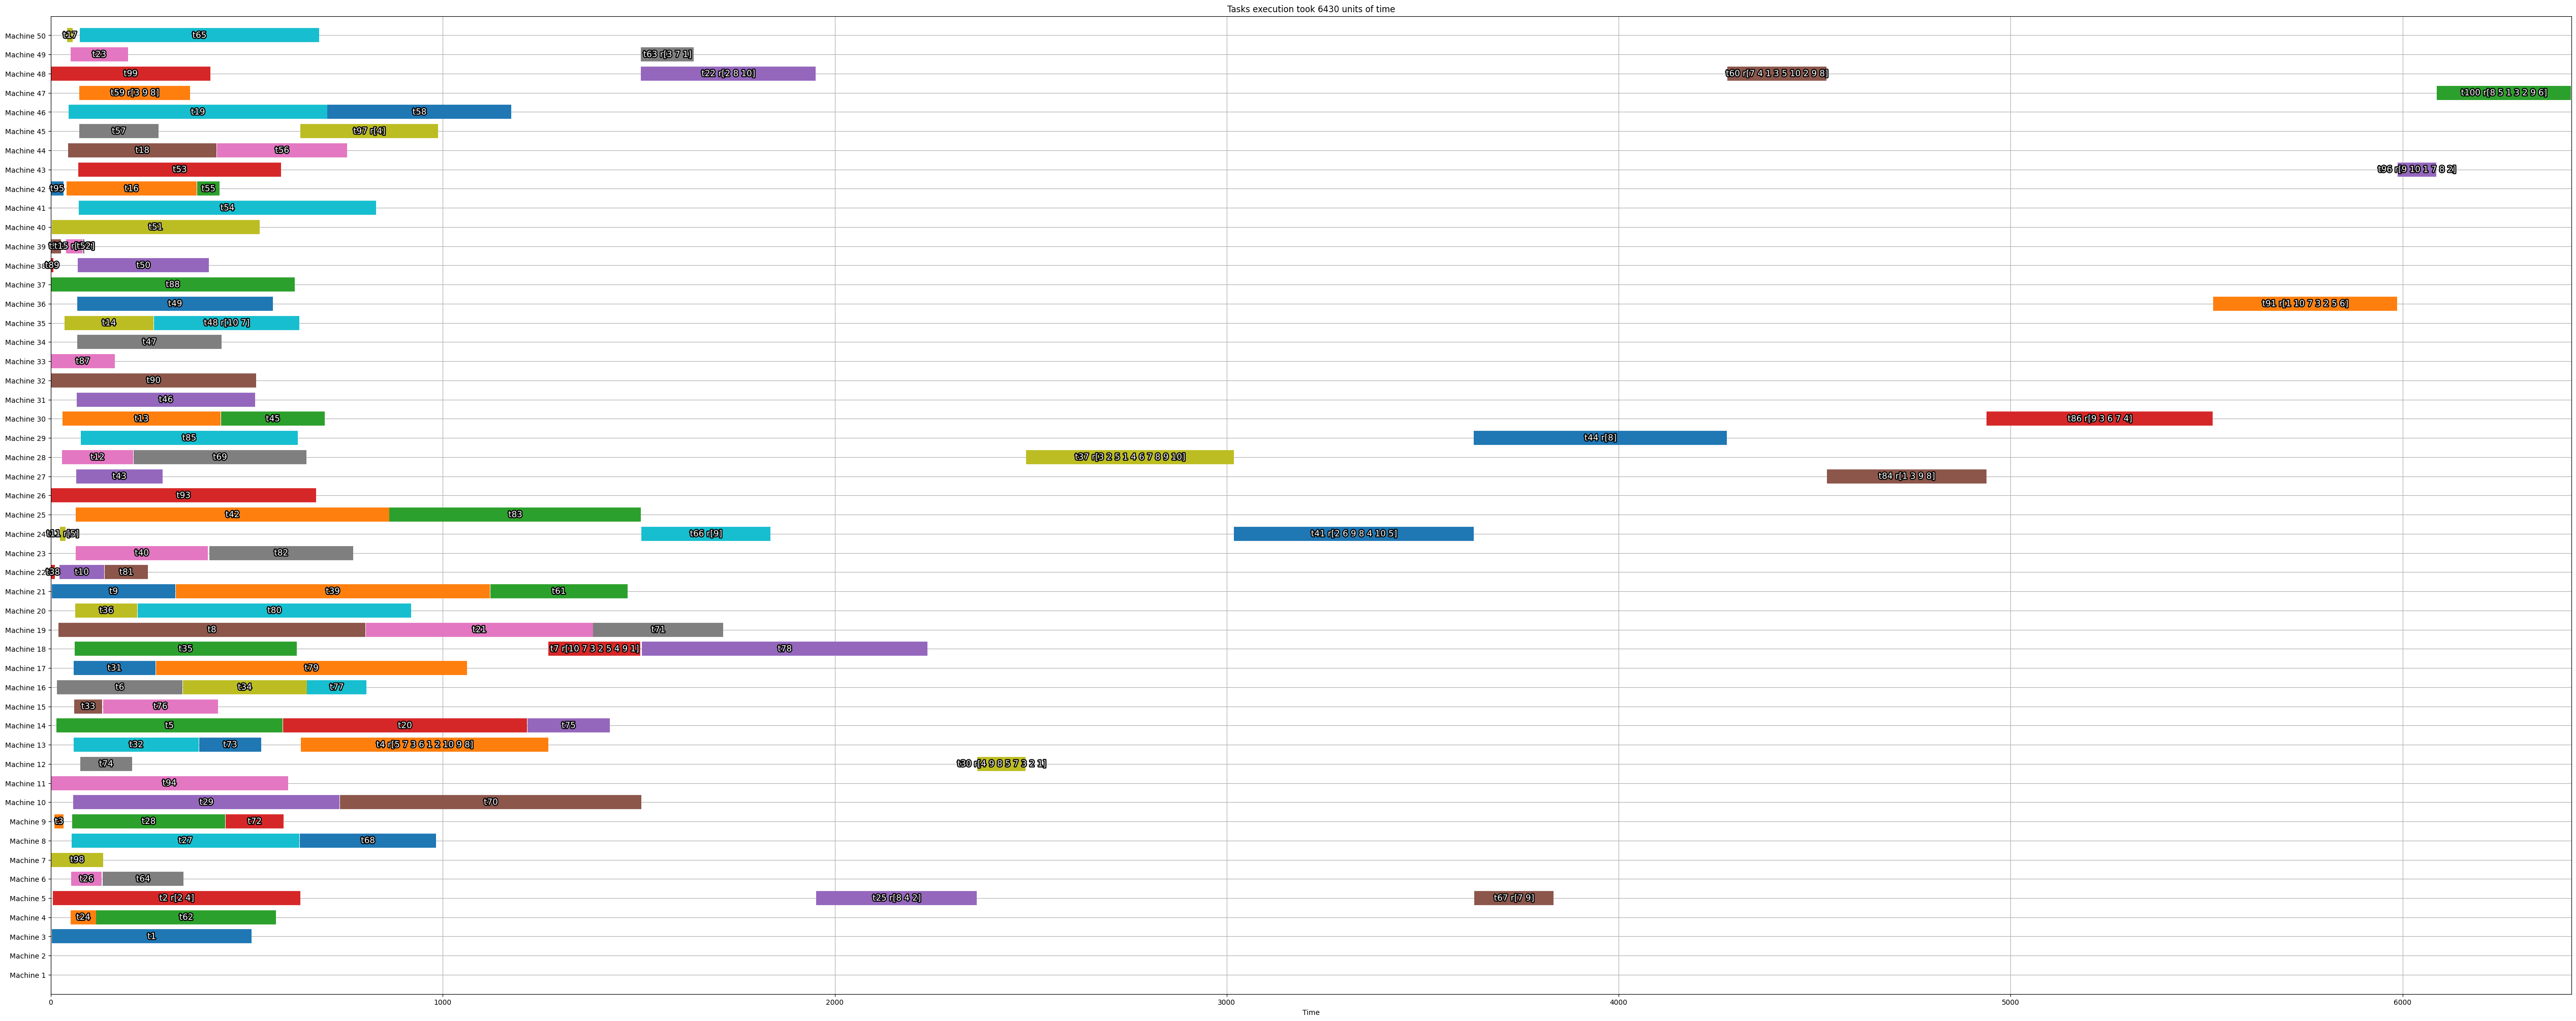

In [128]:
if result in (SAT, OPTIMUM): #drawing the result
    activities = []
    global machines_usages
    for machine in machines_usages:
        machine_activities = []
        for activity, start_time in sorted(machine.items(), key=lambda item: item[1]):
            name, _, _ = activity.split(', ')
            name = name.split('=')[0]  # Extracting the activity name
            start_time = int(start_time)
            duration = int(activity.split(', ')[-1].split('=')[-1])
            machine_activities.append({'name': name, 'start_time': start_time, 'duration': duration})
        activities.append(machine_activities)
    draw_schedule(activities, value(score), max(18, int(value(score)/100)), max(12, int(len(machines_usages)/2)))